# Lightning Flash Dataset: EDA with K-Means Clustering

## Import Libraries

In [21]:
import os
import warnings

import duckdb as db
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # plot styling

# from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from PIL import Image

%matplotlib inline
warnings.filterwarnings('ignore')

## Data Load

In [22]:
# 2.Load dataset - db connections
# test dataset is GOES-West noaa-goes18
conn = db.connect("glmFlash.db") # Path to db file
lat_df = conn.execute("SELECT * FROM tbl_flash_lat;").df() # latitude co-ordinates
lon_df = conn.execute("SELECT * FROM tbl_flash_lon;").df() # longitude co-ordinates
print(lat_df.describe(), "\n")
print(lon_df.describe())

                 lat
count  170638.000000
mean       31.511432
std        12.918724
min       -51.323742
25%        17.642656
50%        36.804962
75%        40.893967
max        55.214820 

                 lon
count  170638.000000
mean      -95.471939
std        11.747338
min      -179.003230
25%       -96.984122
50%       -96.089230
75%       -94.796420
max       179.486240


## Preprocessing

In [23]:
# 3.Preprocess - Cleaning up the data
# assuming each flash point corresponds to a lightning discharge?
lat_df.drop(lat_df.columns[[2]],axis=1,inplace=True)  # drop file name
lon_df.drop(lon_df.columns[[2]],axis=1,inplace=True)  # drop file name
print(lat_df.info(), "\n")
print(lon_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170638 entries, 0 to 170637
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   ts_date  170638 non-null  datetime64[ns]
 1   lat      170638 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.6 MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170638 entries, 0 to 170637
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   ts_date  170638 non-null  datetime64[ns]
 1   lon      170638 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.6 MB
None


In [24]:
# remove duplicates
lat_df.drop_duplicates(subset=['ts_date'], inplace=True)
lon_df.drop_duplicates(subset=['ts_date'], inplace=True)
print(lat_df.ts_date.value_counts(), "\n")
print(lon_df.ts_date.value_counts())

2023-04-20 00:10:59.317923    1
2023-04-20 02:50:10.559245    1
2023-04-20 02:50:11.567867    1
2023-04-20 02:50:11.557949    1
2023-04-20 02:50:11.505686    1
                             ..
2023-04-20 01:14:40.598155    1
2023-04-20 01:14:40.358588    1
2023-04-20 01:14:40.198750    1
2023-04-20 01:14:39.686046    1
2023-04-20 02:09:19.101248    1
Name: ts_date, Length: 87041, dtype: int64 

2023-04-20 00:13:59.588388    1
2023-04-20 02:23:40.114825    1
2023-04-20 02:23:40.189213    1
2023-04-20 02:23:40.565348    1
2023-04-20 02:23:40.373084    1
                             ..
2023-04-20 01:58:14.262230    1
2023-04-20 01:58:13.989473    1
2023-04-20 01:58:13.912416    1
2023-04-20 01:58:14.044407    1
2023-04-20 02:17:18.889910    1
Name: ts_date, Length: 87041, dtype: int64


In [25]:
# join dataframes
geo_df = lon_df.join(lat_df.set_index('ts_date'), on='ts_date')
geo_df.size

261123

In [26]:
# add hour category
geo_df['hour'] = geo_df['ts_date'].dt.hour
# add day category
geo_df['day'] = geo_df['ts_date'].dt.strftime('%m-%d-%y')
# create initial dataset
geo_df_sm = geo_df[(geo_df['hour'] == 00)]
# dataset time window
start = geo_df.ts_date.min()
end = geo_df.ts_date.max()
print(f"Start: {start}; End: {end}")
geo_df_sm

Start: 2023-04-19 23:59:59.601740; End: 2023-04-20 02:59:59.270622


,ts_date,lon,lat,hour,day
0,2023-04-20 00:13:59.588388,-96.771950,16.709520,0,04-20-23
1,2023-04-20 00:13:59.602503,-97.466110,18.480242,0,04-20-23
2,2023-04-20 00:13:59.253071,-96.189064,38.873814,0,04-20-23
3,2023-04-20 00:13:59.783704,-95.980730,40.057100,0,04-20-23
4,2023-04-20 00:13:59.613566,-96.886536,36.140156,0,04-20-23
...,...,...,...,...,...
25755,2023-04-20 00:24:39.077215,-129.353150,-28.376917,0,04-20-23
25756,2023-04-20 00:24:39.109640,-95.745450,42.060165,0,04-20-23
25757,2023-04-20 00:24:38.867022,-96.803460,42.524395,0,04-20-23
70131,2023-04-20 00:59:59.427406,-89.286270,14.118956,0,04-20-23


Text(0.5, 1.0, 'Raw Flash Events')

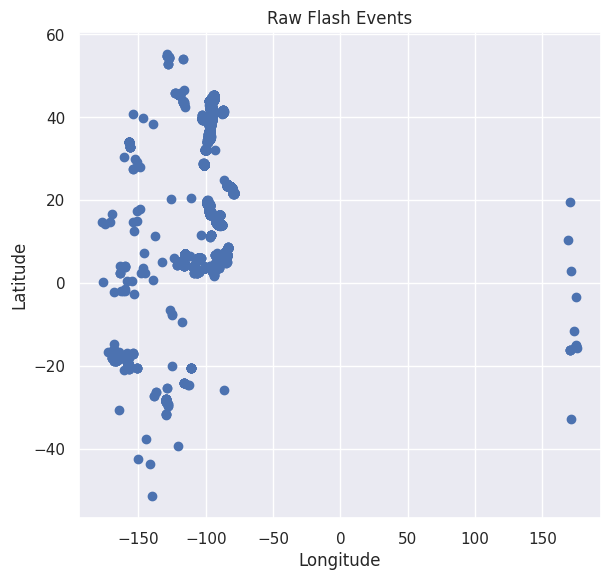

In [27]:
# 3.Raw visualization
plt.figure(figsize=(6, 6))
plt.scatter(x=geo_df_sm['lon'], y=geo_df_sm['lat'])
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.title("Raw Flash Events")

## Clustering

In [28]:
# 4. Implement K-Means clustering algorithm
k = 12
geo_df_sm = geo_df_sm.loc[:, ["lon", "lat"]]
kmeans = KMeans(n_clusters=k)
geo_df_sm["cluster"] = kmeans.fit_predict(geo_df_sm)
geo_df_sm["cluster"] = geo_df_sm["cluster"].astype("category")
geo_df_sm.head()

,lon,lat,cluster
0,-96.771950,16.709520,1
1,-97.466110,18.480242,1
2,-96.189064,38.873814,11
3,-95.980730,40.057100,11
4,-96.886536,36.140156,0


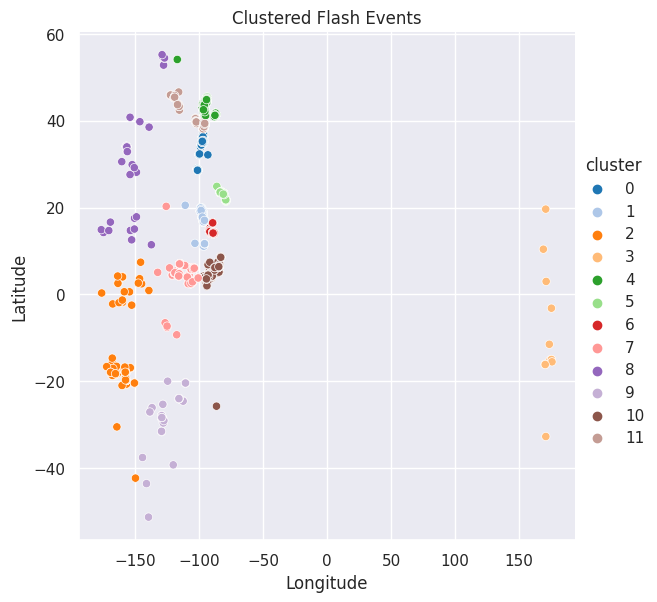

In [29]:
# Plot clusters
g = sns.relplot(
    x="lon", y="lat", hue="cluster", data=geo_df_sm, height=6,  palette="tab20", sizes=(10, 100)
).set(title='Clustered Flash Events', xlabel="Longitude", ylabel="Latitude")

## Evaluations

In [30]:
# 5a. Evaluate results, silhouette score
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}
geo_df_sm = geo_df_sm.loc[:, ["lon", "lat"]]
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Start at 2 clusters for silhouette coefficient
for k in range(2, 24):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(geo_df_sm)
    score = silhouette_score(geo_df_sm, kmeans.labels_)
    silhouette_coefficients.append(score)

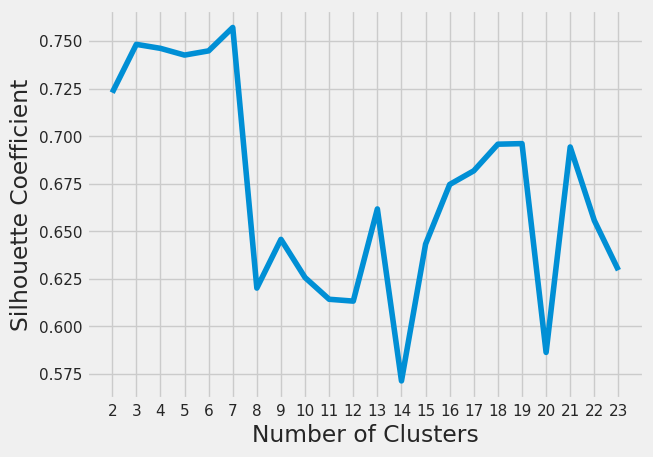

In [31]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 24), silhouette_coefficients)
plt.xticks(range(2, 24))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [39]:
# 5b. Evaluate results, elbow method
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 100,
    "random_state": 45,
}

# holds the sum of the squared distances for each k
ssd = []

# Return ssd for each k
for k in range(1, 24):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(geo_df_sm)
    ssd.append(kmeans.inertia_)

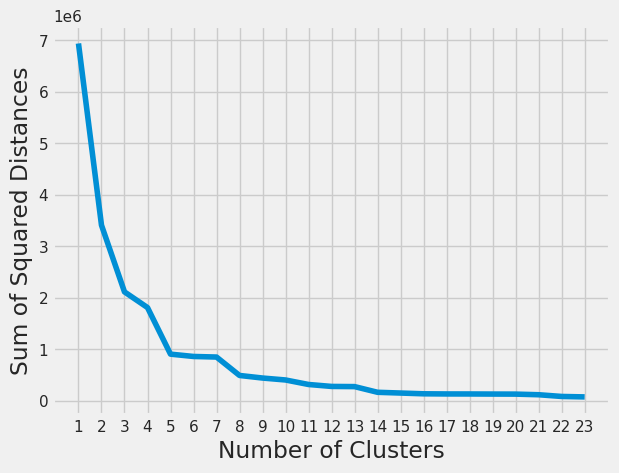

In [41]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 24), ssd)
plt.xticks(range(1, 24))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Distances")
plt.show()

## Plotting

In [14]:
# 6. Overlay cluster on "world" map
# load US regions shape file
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
print(world.crs)

EPSG:4326


In [15]:
# Convert DataFrame to GeoDataFrame
geo = gpd.GeoDataFrame(geo_df_sm, geometry=gpd.points_from_xy(geo_df_sm.lon, geo_df_sm.lat))

# coodinate reference system (CRS) to EPSG 4326
geo.crs = {'init': 'epsg:4326'}
geo.head()

,lon,lat,cluster,geometry
0,-96.771950,16.709520,8,POINT (-96.77195 16.70952)
1,-97.466110,18.480242,8,POINT (-97.46611 18.48024)
2,-96.189064,38.873814,9,POINT (-96.18906 38.87381)
3,-95.980730,40.057100,9,POINT (-95.98073 40.05710)
4,-96.886536,36.140156,5,POINT (-96.88654 36.14016)


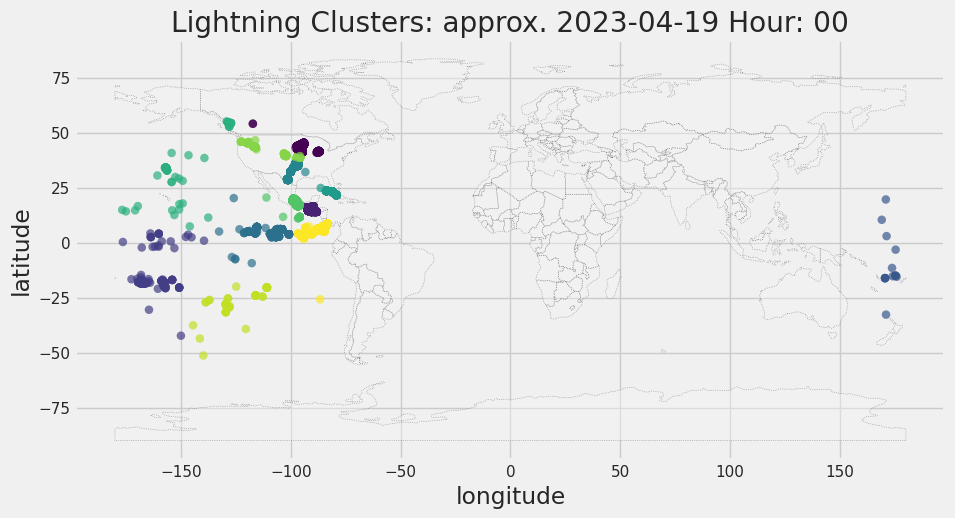

In [16]:
# plot map
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
world.plot(ax=ax, alpha=0.4, color='whitesmoke', linestyle=':', edgecolor='black', zorder=1)
geo.plot(ax=ax, column="cluster", alpha=0.7, cmap='viridis', linewidth=0.1, zorder=2)
plt.title(f"Lightning Clusters: approx. {start.date()} Hour: 00") # i.e. Start: 2023-04-19 23:59:59.601740; End: 2023-04-20 12:59:58.608381
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()

DataFrame shape: 25703
Generating clusters for 04-19-23 on hour: 0; k=12
DataFrame shape: 31744
Generating clusters for 04-19-23 on hour: 1; k=12
DataFrame shape: 29591
Generating clusters for 04-19-23 on hour: 2; k=12
DataFrame shape: 3
Generating clusters for 04-19-23 on hour: 23; k=12
DataFrame shape: 25703
Generating clusters for 04-20-23 on hour: 0; k=12
DataFrame shape: 31744
Generating clusters for 04-20-23 on hour: 1; k=12
DataFrame shape: 29591
Generating clusters for 04-20-23 on hour: 2; k=12
DataFrame shape: 3
Generating clusters for 04-20-23 on hour: 23; k=12


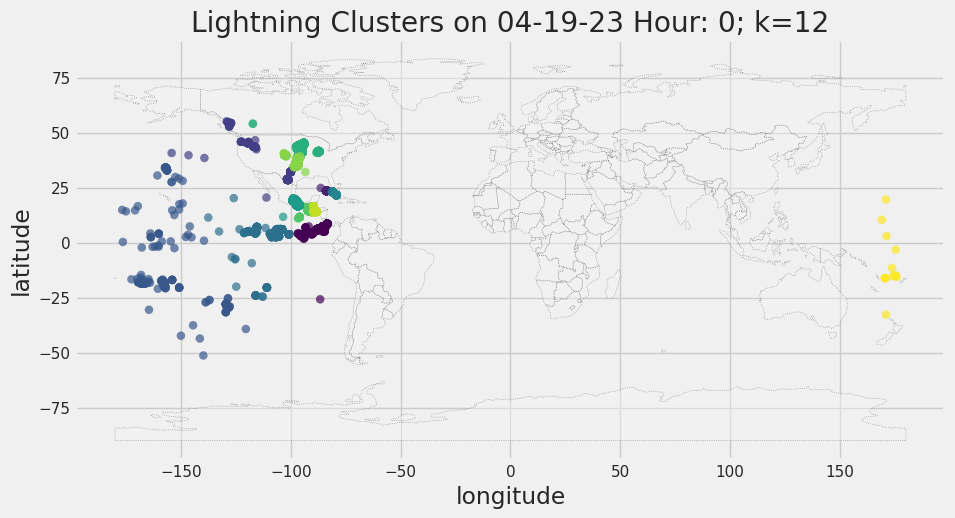

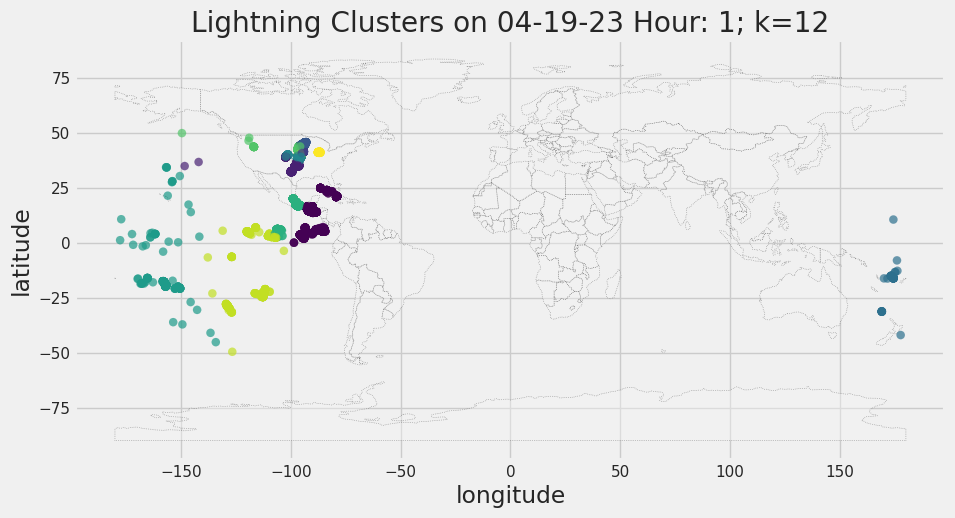

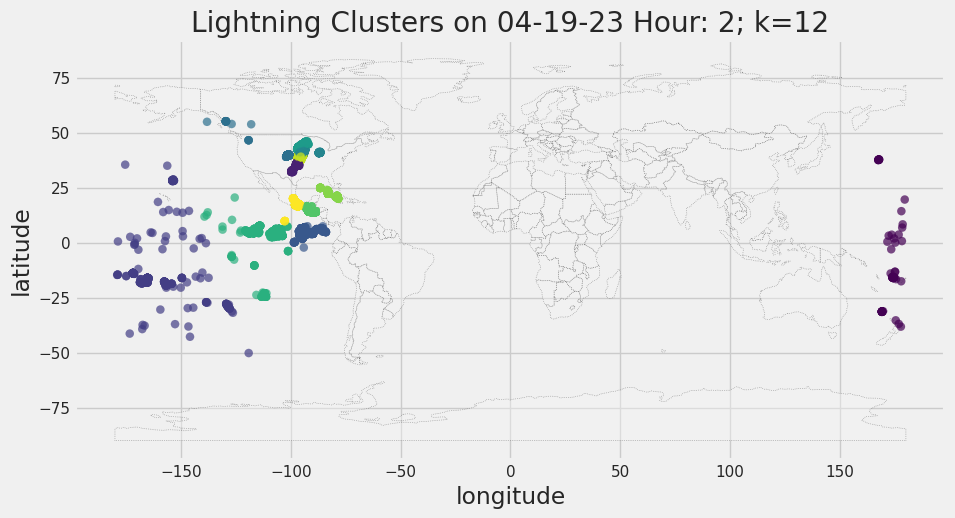

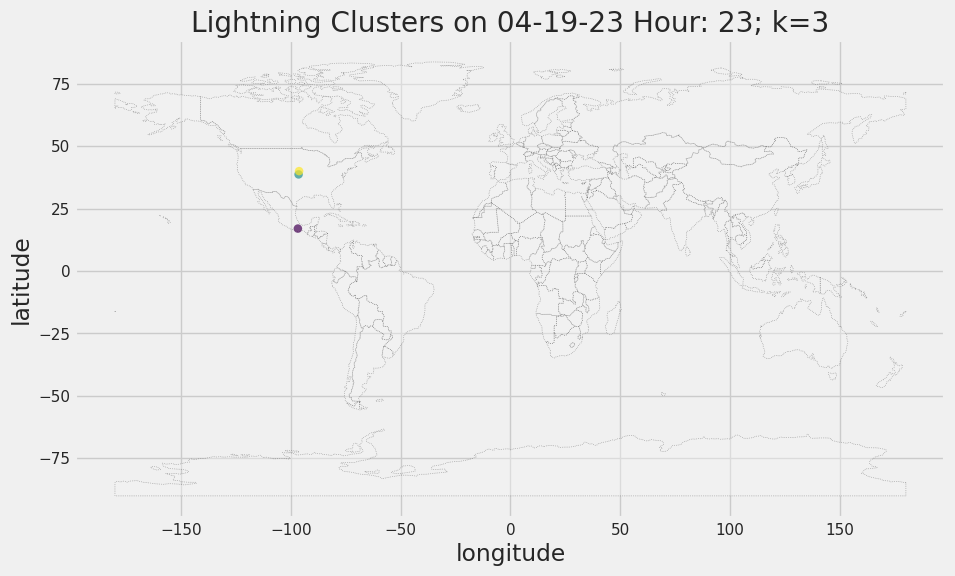

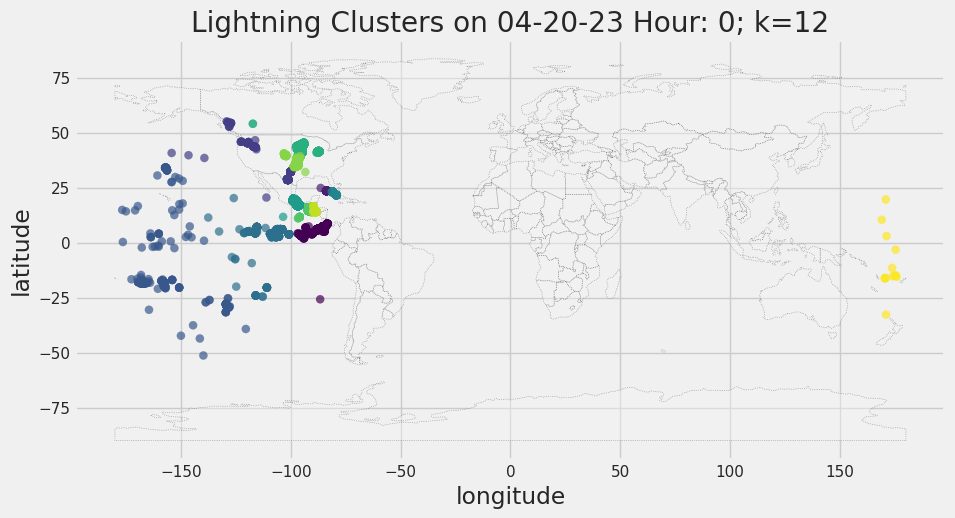

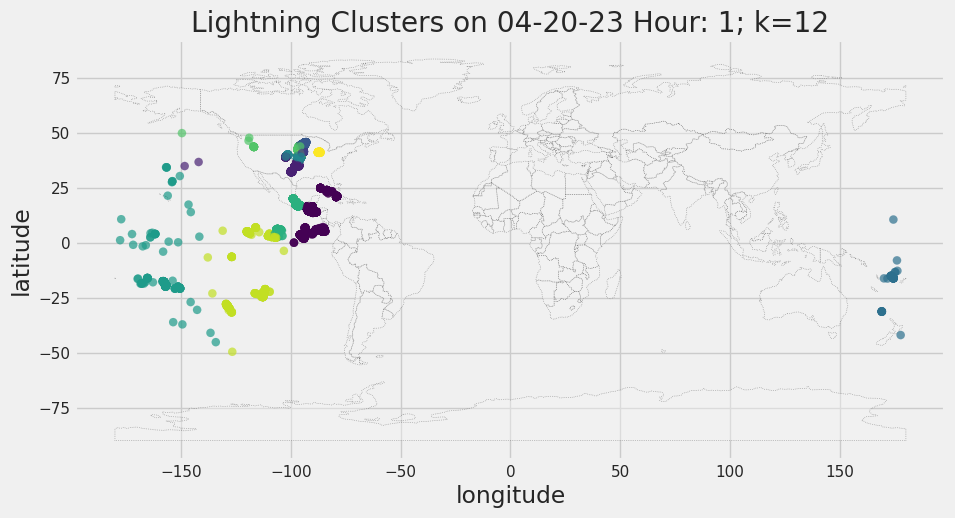

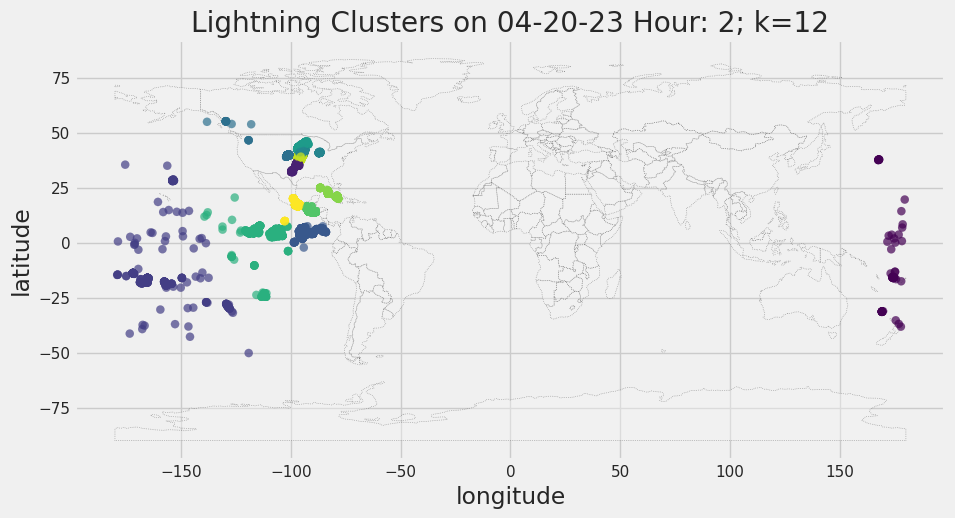

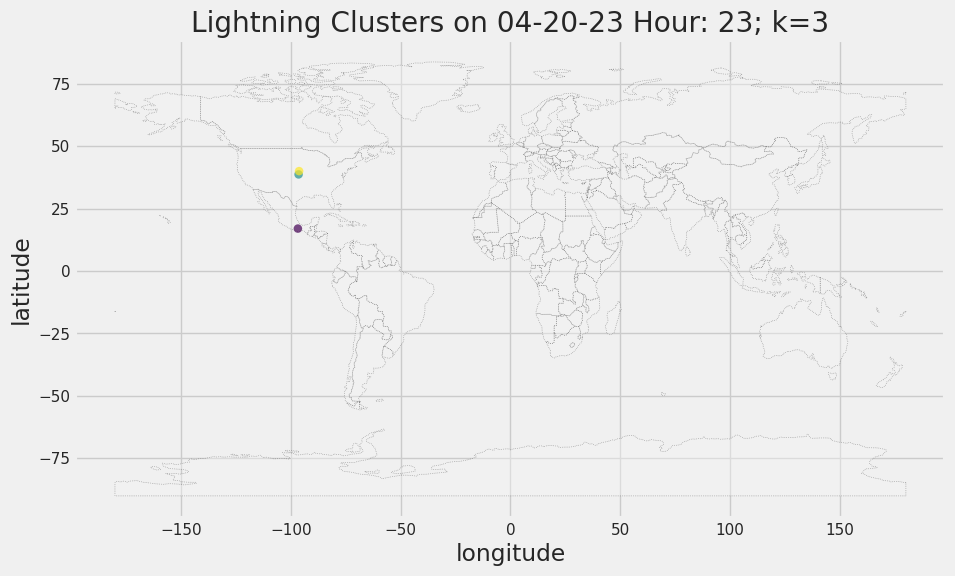

In [17]:
# 7. Create simple time lapse
num_clusters = 12
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 100,
    "random_state": 42,
}
DayList = geo_df['day'].drop_duplicates().to_list()
hourList = geo_df['hour'].drop_duplicates().to_list()
DayList.sort()
hourList.sort()
for j in DayList:
    for i in hourList:
        k = num_clusters
        geo_df_n = geo_df[(geo_df['hour'] == i)]
        geo_df_n = geo_df_n.loc[:, ["lon", "lat"]]
        num_samples = geo_df_n.shape[0]
        print(f"DataFrame shape: {num_samples}")
        if num_clusters >= num_samples:
            k = num_samples
        else:
            pass

        print(f"Generating clusters for {j} on hour: {i}; k={num_clusters}")
        
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        geo_df_n["cluster"] = kmeans.fit_predict(geo_df_n)
        geo_df_n["cluster"] = geo_df_n["cluster"].astype("category")
                    
        # Convert DataFrame to GeoDataFrame
        geo = gpd.GeoDataFrame(geo_df_n, geometry=gpd.points_from_xy(geo_df_n.lon, geo_df_n.lat))

        # coodinate reference system (CRS) to EPSG 4326
        geo.crs = {'init': 'epsg:4326'}

        # plot map
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_aspect('equal')
        world.plot(ax=ax, alpha=0.4, color='whitesmoke', linestyle=':', edgecolor='black', zorder=1)
        geo.plot(ax=ax, column="cluster", alpha=0.7, cmap='viridis', linewidth=0.1, zorder=2)
        plt.title(f"Lightning Clusters on {j} Hour: {i}; k={k}")
        plt.xlabel("longitude")
        plt.ylabel("latitude")
        # plt.show()
        filename = f"maps/lightning_clusters_{j}_{i}.png"
        fig.savefig(f"{filename}", bbox_inches="tight", dpi=600)

In [19]:
# Combine images to gif
import glob
from IPython.display import HTML

filePath = f"maps/sample_lightning_clusters.gif"

def png_to_gif(images_path, file_path, duration=500):
    frames = []
    images = glob.glob(images_path)

    for i in sorted(images):
        im = Image.open(i)
        im = im.resize((600,400), Image.ANTIALIAS)
        frames.append(im.copy())

    frames[0].save(f"{file_path}", format="GIF", append_images=frames[1:], save_all=True)

png_to_gif(images_path="maps/*.png", file_path=filePath, duration=900)



In [20]:
HTML(f'<img src="{filePath}", width="750", align="center">')